In [458]:
%matplotlib inline
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json

# https://pypi.org/project/pygeocoder/
from pygeocoder import Geocoder

# Google developer API key
from config import gkey

In [459]:
# File to Load
data_to_load = "data/Meteorite_Landings.csv"
meteor_landings = pd.read_csv(data_to_load, parse_dates=True)

# Display the data table for preview
meteor_landings.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,States,Counties
0,Aachen,1,Valid,L5,21.0,Fell,01/01/1880 12:00:00 AM,50.77500,6.08333,"(50.775, 6.08333)",NaN,NaN
1,Aarhus,2,Valid,H6,720.0,Fell,01/01/1951 12:00:00 AM,56.18333,10.23333,"(56.18333, 10.23333)",NaN,NaN
2,Abee,6,Valid,EH4,107000.0,Fell,01/01/1952 12:00:00 AM,54.21667,-113.00000,"(54.21667, -113.0)",NaN,NaN
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,01/01/1976 12:00:00 AM,16.88333,-99.90000,"(16.88333, -99.9)",NaN,NaN
4,Achiras,370,Valid,L6,780.0,Fell,01/01/1902 12:00:00 AM,-33.16667,-64.95000,"(-33.16667, -64.95)",NaN,NaN


In [460]:
# Refine source data into a starting DataFrame
meteor_landings_df = meteor_landings.filter(['name','mass (g)','fall','year','reclat','reclong'], axis=1)
meteor_landings_df = meteor_landings_df.rename(columns={'mass (g)': 'mass',
                                                        'year': 'date',
                                                        'reclat': 'latitude',
                                                        'reclong': 'longitude'})

# Convert the mass value from grams (g) to kilograms (kg)
meteor_landings_df['mass'] /= 1000

print(len(meteor_landings_df))
meteor_landings_df.head()

45716


,name,mass,fall,date,latitude,longitude
0,Aachen,0.021,Fell,01/01/1880 12:00:00 AM,50.77500,6.08333
1,Aarhus,0.720,Fell,01/01/1951 12:00:00 AM,56.18333,10.23333
2,Abee,107.000,Fell,01/01/1952 12:00:00 AM,54.21667,-113.00000
3,Acapulco,1.914,Fell,01/01/1976 12:00:00 AM,16.88333,-99.90000
4,Achiras,0.780,Fell,01/01/1902 12:00:00 AM,-33.16667,-64.95000


In [461]:
# Remove dates outside 584 year range and replace with NaT
meteor_landings_df['date'] = pd.to_datetime(meteor_landings_df['date'], errors='coerce').dt.year

In [462]:
# Create a copy of date cleared DataFrame for use for the scatter plot later
meteor_landings_nat = meteor_landings_df

# Remove 'date' Nat and zero mass
meteor_landings_nat = meteor_landings_nat.dropna(subset=['date'])
meteor_landings_nat = meteor_landings_nat[meteor_landings_nat.mass > 0]

print(len(meteor_landings_nat))
meteor_landings_nat.head()

45277


,name,mass,fall,date,latitude,longitude
0,Aachen,0.021,Fell,1880.0,50.77500,6.08333
1,Aarhus,0.720,Fell,1951.0,56.18333,10.23333
2,Abee,107.000,Fell,1952.0,54.21667,-113.00000
3,Acapulco,1.914,Fell,1976.0,16.88333,-99.90000
4,Achiras,0.780,Fell,1902.0,-33.16667,-64.95000


In [463]:
# Clean-up DataFrame:
#     Remove rows with NaN/NaT values in year, reclat or reclong
#     Filter to remove landings below -59 to exlude Antarctic

print('Before: ', len(meteor_landings_df))

meteor_landings_df = meteor_landings_df.dropna(subset=['date','latitude','longitude'])
meteor_landings_df = meteor_landings_df[meteor_landings_df.latitude != 0]
meteor_landings_df = meteor_landings_df[meteor_landings_df.latitude > -59]

print('After: ', len(meteor_landings_df))

Before:  45716
After:  9693


In [464]:
# Add two blank columns that we'll need for reverse gecoding
meteor_landings_df['admin_level_1'] = ''
meteor_landings_df['country'] = ''

meteor_landings_df.head()

,name,mass,fall,date,latitude,longitude,admin_level_1,country
0,Aachen,0.021,Fell,1880.0,50.77500,6.08333,,
1,Aarhus,0.720,Fell,1951.0,56.18333,10.23333,,
2,Abee,107.000,Fell,1952.0,54.21667,-113.00000,,
3,Acapulco,1.914,Fell,1976.0,16.88333,-99.90000,,
4,Achiras,0.780,Fell,1902.0,-33.16667,-64.95000,,


In [465]:
# Create a new DataFrame of a sample of the source
sample_size = 50

rand_meteor_landings = meteor_landings_df.sample(n=sample_size)
rand_meteor_landings.reset_index(drop=True, inplace=True)

rand_meteor_landings

,name,mass,fall,date,latitude,longitude,admin_level_1,country
0,Dhofar 1695,0.326000,Found,2010.0,19.09578,54.80188,,
1,Acfer 194,0.361000,Found,1991.0,27.49944,3.68889,,
2,Acfer 039,0.225000,Found,1989.0,27.53333,3.91667,,
3,Jiddat al Harasis 604,0.754000,Found,2009.0,19.78957,55.97618,,
4,Monroe,8.600000,Fell,1849.0,35.25000,-80.50000,,
5,O'Malley 013,0.007300,Found,2011.0,-30.88561,131.38197,,
6,Dar al Gani 526,0.049000,Found,1997.0,27.06850,16.10700,,
7,Colony,3.912000,Found,1975.0,35.35000,-98.68333,,
8,El Médano 002,0.012000,Found,2010.0,-24.85000,-70.53333,,
9,Rogers,0.982000,Found,1974.0,34.06500,-103.40833,,


In [466]:
keyed_geocoder = Geocoder(api_key = gkey)

In [467]:
# Use Google Geocoding API to reverse lookup lat & long to get country and state

for row in range(len(rand_meteor_landings)):
    result = keyed_geocoder.reverse_geocode(rand_meteor_landings['latitude'][row],
                                            rand_meteor_landings['longitude'][row])
    rand_meteor_landings.loc[row,'admin_level_1'] = result.administrative_area_level_1
    rand_meteor_landings.loc[row,'country'] = result.country

print(len(rand_meteor_landings))

50


In [468]:
rand_meteor_landings.head()

,name,mass,fall,date,latitude,longitude,admin_level_1,country
0,Dhofar 1695,0.326,Found,2010.0,19.09578,54.80188,Dhofar Governorate,Oman
1,Acfer 194,0.361,Found,1991.0,27.49944,3.68889,Tamanrasset Province,Algeria
2,Acfer 039,0.225,Found,1989.0,27.53333,3.91667,Tamanrasset Province,Algeria
3,Jiddat al Harasis 604,0.754,Found,2009.0,19.78957,55.97618,Al Wusta Governorate,Oman
4,Monroe,8.600,Fell,1849.0,35.25000,-80.50000,North Carolina,United States


In [476]:
# Create a DataFrame for the scatter plot
bubble_df = meteor_landings_nat.groupby(['date'], as_index=False)\
.agg({'mass': 'sum', 'name': 'count'})
bubble_df = bubble_df.rename(columns={'date': 'year', 'name': 'count'})

bubble_df.head(10)

,year,mass,count
0,1688.0,0.695,1
1,1715.0,7.000,1
2,1716.0,1.700,1
3,1723.0,0.039,1
4,1724.0,98.000,1
5,1740.0,24.700,1
6,1741.0,14.360,1
7,1749.0,700.000,1
8,1751.0,49.000,1
9,1753.0,21.540,2


In [470]:
# Plot x-axis = bins of half-centuries
# y-axis = sum of landings

bins = [1675,1700,1725,1750,1775,1800,1825,1850,1875,1900,1925,1950,1975,2000,2025]
bin_labels = ['1676-1700','1701-1725','1726-1750','1751-1775','1776-1800',
              '1801-1825','1826-1850','1851-1875','1876-1900','1901-1925','1926-1950',
              '1951-1975','1976-2000','2001-2025']

In [471]:
# Bin into 25 year groups
bubble_df['years_bin'] = pd.cut(bubble_df['year'], bins, labels=bin_labels)

bubble_df.head()

,year,mass,count,years_bin
0,1688.0,0.695,1,1676-1700
1,1715.0,7.000,1,1701-1725
2,1716.0,1.700,1,1701-1725
3,1723.0,0.039,1,1701-1725
4,1724.0,98.000,1,1701-1725


In [472]:
# Group by the bins
plot_df = bubble_df.groupby(['years_bin'], as_index=False)\
.agg({'mass': 'sum', 'count': 'sum'})

plot_df

,years_bin,mass,count
0,1676-1700,0.695000,1
1,1701-1725,106.739000,4
2,1726-1750,739.060000,3
3,1751-1775,101.940000,8
4,1776-1800,10213.580500,17
5,1801-1825,65928.241300,69
6,1826-1850,32571.918200,100
7,1851-1875,77780.319900,206
8,1876-1900,77330.859400,306
9,1901-1925,124752.383650,372


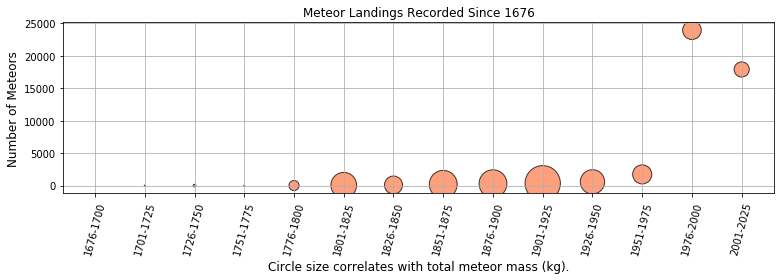

In [480]:
# Variables to control apperance of the scatter plot
plot_alpha = 0.75 #alpha value
scatter_size = .01 #scatter size multiplier
xlabel_rotation = 75 #dedgree rotation for the x-label ticks
font_size = 12 #font size used for x,y labels (not tick mark labels)

# Build the scatter plots for each city types
plt.scatter(x=plot_df['years_bin'], y=plot_df['count'], marker="o", facecolors="coral", edgecolors="black",
            s=plot_df['mass']*scatter_size, alpha=plot_alpha)
plt.xticks(plot_df['years_bin'], rotation=xlabel_rotation)
plt.rcParams["figure.figsize"] = [9,4]
plt.grid()

# Incorporate the other graph properties
plt.title('Meteor Landings Recorded Since 1676')
plt.xlabel('Circle size correlates with total meteor mass (kg).', fontsize=font_size)
plt.ylabel('Number of Meteors', fontsize=font_size)

# Save Figure
# plt.tight_layout()
# plt.savefig('bubble.png')

In [474]:
# basemap world with landings

In [475]:
# Overlay California sum of landings & mass over map